# 🖊 MNIST: Automatic Handwritten Digit Recognition

---

## ❔What is MNIST

**MNIST** (Modified National Institute of Standards and Technology) is a classic dataset of handwritten digits (0–9), with 60,000 training images and 10,000 test images, each 28×28 pixels in size (black and white ⚫️⚪️)

[Examine MNIST Dataset from PyTorch Torchvision](https://www.datascienceweekly.org/tutorials/examine-mnist-dataset-from-pytorch-torchvision)

---

## 📍 Goal
*   In this notebook, we will experiment with 3 Neural Networks to test and compare their
performance and accuracy

---



🎨 MNIST image samples

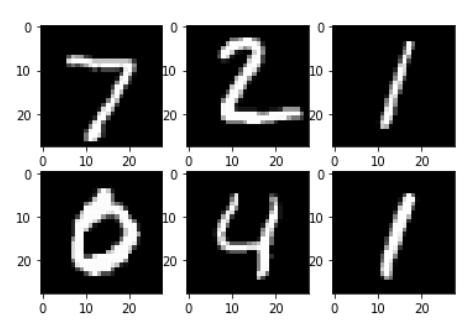

# 🌐 **Neural Networks**:


---


1) **Multi-Layer Perceptron (MLP)**: Consists of a fully connected hidden layer with 100 neurons, followed by a Softmax layer to output class probabilities. It is suitable for tasks where the input features are already flattened or structured.

2) **Convolutional Neural Network (CNN)**: it has two convolutional blocks: the first with 32 filters and the second with 64 filters, both using 3×3 kernels and stride 1. Each block is followed by a 2×2 max-pooling layer and a ReLU activation. The resulting feature map is flattened and passed to a dense layer (1600 → 10), followed by a Softmax activation to produce class probabilities

3) **MobileNetV2 (frozen)**: A pretrained CNN with approximately 3.5 million parameters, designed for resource-constrained devices. In this setup, the network layers are frozen and used as a feature extractor, leveraging its prior training on the ImageNet dataset to process new images efficiently.

🧪 **Hyper-parameters for all 3 networks**:


---


- Mini-batch size = 100
- Learning rate = 0.001
- Epochs for MLP = 5
- Epochs for CNN = 5
- Epochs for MobileNetV2 = 3
- Optimizer: Adam
- Loss function: Cross-entropy


---



## 🧩 PyTorch Installations


In [1]:
print("Install 1. torch 2. torchvision 3. torchaudio")
!pip install -q torch torchvision torchaudio --upgrade

Install 1. torch 2. torchvision 3. torchaudio


## 🧩 Imports

In [2]:
print("Import necessary packages")
import time, os, copy, csv
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from statistics import mean, stdev
print("Import completed!")
print("PyTorch version:", torch.__version__)

Import necessary packages
Import completed!
PyTorch version: 2.9.1+cu128


## 🧩 GPU/CPU Check
📝 **Note**: How to check if you are using GPU/CPU

💡In Colab: Runtime > Change Runtime Type

?) What's the difference: Training models like CNNs or MobileNetV2 on MNIST is much faster on GPU than CPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 🧩 Hyperparameters

In [4]:
MINI_BATCH_SIZE = 100
LEARNING_RATE = 0.001
MLP_EPOCHS = 5
CNN_EPOCHS = 5
MOBILENETV2_EPOCHS = 3
GPU_EXECUTIONS = 5

## ⚙️ MNIST Mean and Std Value
📝 **Note**: The values below are not random! [Calculating MNIST mean & std](https://www.kaggle.com/code/berrywell/calculating-mnist-inverted-mnist-mean-std)

In [5]:
# MNIST is grayscale, so it has 1 channel, thus a single-value tuple
mnist_mean = (0.1307,)
mnist_std = (0.3081,)

## ⚙️ ImageNet Mean and Std Value
📝 **Note**: The values below are not random! [ImageNet explained](https://en.wikipedia.org/wiki/ImageNet)

In [6]:
# ImageNet is RGB, 3 channels
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# 🔬 Training & Testing

##🔗 Pipeline: Convert MNIST images to PyTorch tensors

In [7]:
transform_base = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
])

## 🔗 Pipeline: Convert MNIST images to MobileNetV2 format

In [8]:
transform_mobilenet = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

## 📝 MNIST Train and Test Data

In [9]:
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform_base)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform_base)

In [10]:
train_dataset_mobileNet = datasets.MNIST(root="./data", train=True, download=True, transform=transform_mobilenet)
test_dataset_mobileNet = datasets.MNIST(root="./data", train=False, download=True, transform=transform_mobilenet)

🧩 DataLoaders for loading and processing data

In [11]:
train_loader = DataLoader(train_dataset, batch_size=MINI_BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=MINI_BATCH_SIZE, shuffle=False)

In [12]:
train_loader_mobileNet = DataLoader(train_dataset_mobileNet, batch_size=MINI_BATCH_SIZE, shuffle=True)
test_loader_mobileNet  = DataLoader(test_dataset_mobileNet, batch_size=MINI_BATCH_SIZE, shuffle=False)

🧠 MLP1 — 1 hidden layer

In [13]:
class MLP1(nn.Module):
    def __init__(self, input_dim=28*28, hidden=100, num_classes=10):
        super().__init__()
        # Fully connected layer from input to hidden layer
        self.fc1 = nn.Linear(input_dim, hidden)
        # Fully connected layer from hidden layer to output layer
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x):
        # Flatten the input tensor (batch_size, 28, 28) → (batch_size, 784)
        x = x.view(x.size(0), -1)
        # Apply ReLU activation after the first linear layer
        x = F.relu(self.fc1(x))
        # Compute raw scores for each class (logits)
        x = self.fc2(x)
        return x

🧠 CNN

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # First convolutional layer:
        # Input channels = 1 (grayscale), Output channels = 32 filters,
        # Kernel size = 3x3, stride = 1, padding = 1 (to keep spatial size)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)

        # First max-pooling layer:
        # Kernel size = 2x2, reduces spatial dimensions by 2
        self.pool1 = nn.MaxPool2d(2,2)

        # Second convolutional layer:
        # Input channels = 32 (from previous conv), Output channels = 64 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Second max-pooling layer (2x2)
        self.pool2 = nn.MaxPool2d(2,2)

        # Fully connected layer:
        # Input size = 64 channels * 7 * 7 (after 2 pooling layers on 28x28 input)
        # Output size = 10 classes
        self.fc = nn.Linear(64*7*7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))    # Apply first convolution + ReLU activation
        x = self.pool1(x)            # Apply first max-pooling
        x = F.relu(self.conv2(x))    # Apply second convolution + ReLU activation
        x = self.pool2(x)            # Apply second max-pooling
        x = x.view(x.size(0), -1)    # Flatten tensor to (batch_size, features) for fully connected layer
        x = self.fc(x)               # Fully connected layer (produces logits)
        return x

🧠 MobileNetV2 (pretrained + frozen)

In [15]:
from torchvision import models

def get_mobilenet_frozen():
    # Load pretrained MobileNetV2 with ImageNet weights
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

    # Get the number of input features to the final classifier layer
    in_features = model.classifier[1].in_features

    # Replace the final fully connected layer to output 10 classes instead of 1000
    model.classifier[1] = nn.Linear(in_features, 10)

    # Freeze all convolutional layers (feature extractor)
    # This prevents their weights from being updated during training
    for param in model.features.parameters():
        param.requires_grad = False
    return model

In [16]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    # Set the model to training mode
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    # Iterate over batches
    for data, targets in loader:
        # Move input and target tensors to the specified device (CPU or GPU)
        data, targets = data.to(device), targets.to(device)

        # Zero the gradients from the previous step
        optimizer.zero_grad()

        # Compute model outputs
        outputs = model(data)

        # Compute the loss between predictions and true targets
        loss = criterion(outputs, targets)

        # Compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate loss (weighted by batch size)
        running_loss += loss.item() * data.size(0)

        # Get predicted classes
        _, preds = outputs.max(1)

        # Update total number of samples and correct predictions
        total += targets.size(0)
        correct += (preds == targets).sum().item()

    epoch_loss = running_loss / total
    epoch_acc  = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [17]:
def evaluate(model, loader, criterion, device):
    # Set model to evaluation mode
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    # Record start time for evaluation
    start = time.time()

    # Disable gradient computation for evaluation
    with torch.no_grad():
        for data, targets in loader:

            # Move data and targets to the specified device
            data, targets = data.to(device), targets.to(device)

            # Compute model outputs
            outputs = model(data)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Accumulate total loss (weighted by batch size)
            running_loss += loss.item() * data.size(0)

            # Get predicted classes
            _, preds = outputs.max(1)

            # Update total samples and correct predictions
            total += targets.size(0)
            correct += (preds == targets).sum().item()

    # Compute total evaluation time
    total_time = time.time() - start
    accuracy = 100.0 * correct / total
    loss = running_loss / total

    return loss, accuracy, total_time

In [18]:
def run_experiment(model_factory, model_name, epochs, train_loader, test_loader, device, runs=5):
    results = []

    for r in range(runs):
        print(f"\n=== {model_name} | Run {r+1}/{runs} ===")

        model = model_factory().to(device)
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        # TRAIN
        start_train = time.time()
        for epoch in range(epochs):
            loss, acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
            print(f"Epoch {epoch+1}/{epochs} - loss: {loss:.4f}, acc: {acc:.2f}%")
        train_time = time.time() - start_train

        # TEST
        test_loss, test_acc, test_time = evaluate(model, test_loader, criterion, device)

        print(f"→ Test Acc: {test_acc:.2f}%, Train time: {train_time:.2f}s, Test time: {test_time:.4f}s")

        results.append((test_acc, train_time, test_time))

    # Statistics
    accuracies = [x[0] for x in results]
    train_times = [x[1] for x in results]
    test_times  = [x[2] for x in results]

    print("\n===== SUMMARY =====")
    print(f"Model: {model_name}")
    print(f"Accuracy Mean: {np.mean(accuracies):.2f}%  Std: {np.std(accuracies):.2f}")
    print(f"Train Time Mean: {np.mean(train_times):.2f}s")
    print(f"Test Time Mean:  {np.mean(test_times):.4f}s")

    return results

### 🧠 MLP

In [19]:
# --------------------------------------------------
# MLP
# --------------------------------------------------
mlp_results = run_experiment(
    model_factory=lambda: MLP1(),
    model_name="MLP1",
    epochs=5,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)


=== MLP1 | Run 1/5 ===
Epoch 1/5 - loss: 0.2927, acc: 91.56%
Epoch 2/5 - loss: 0.1327, acc: 96.07%
Epoch 3/5 - loss: 0.0932, acc: 97.24%
Epoch 4/5 - loss: 0.0715, acc: 97.87%
Epoch 5/5 - loss: 0.0579, acc: 98.20%
→ Test Acc: 97.45%, Train time: 66.03s, Test time: 2.0643s

=== MLP1 | Run 2/5 ===
Epoch 1/5 - loss: 0.3013, acc: 91.48%
Epoch 2/5 - loss: 0.1397, acc: 95.86%
Epoch 3/5 - loss: 0.0981, acc: 97.02%
Epoch 4/5 - loss: 0.0750, acc: 97.76%
Epoch 5/5 - loss: 0.0605, acc: 98.18%
→ Test Acc: 97.44%, Train time: 60.51s, Test time: 2.0975s

=== MLP1 | Run 3/5 ===
Epoch 1/5 - loss: 0.2951, acc: 91.48%
Epoch 2/5 - loss: 0.1325, acc: 96.09%
Epoch 3/5 - loss: 0.0925, acc: 97.21%
Epoch 4/5 - loss: 0.0712, acc: 97.89%
Epoch 5/5 - loss: 0.0549, acc: 98.30%
→ Test Acc: 97.39%, Train time: 61.85s, Test time: 1.7976s

=== MLP1 | Run 4/5 ===
Epoch 1/5 - loss: 0.2988, acc: 91.46%
Epoch 2/5 - loss: 0.1374, acc: 95.94%
Epoch 3/5 - loss: 0.0960, acc: 97.18%
Epoch 4/5 - loss: 0.0727, acc: 97.85%
Epoch

### 🧠 CNN

In [20]:
# --------------------------------------------------
# CNN
# --------------------------------------------------
cnn_results = run_experiment(
    model_factory=lambda: SimpleCNN(),
    model_name="CNN",
    epochs=5,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device
)


=== CNN | Run 1/5 ===
Epoch 1/5 - loss: 0.1581, acc: 95.35%
Epoch 2/5 - loss: 0.0495, acc: 98.48%
Epoch 3/5 - loss: 0.0367, acc: 98.88%
Epoch 4/5 - loss: 0.0275, acc: 99.14%
Epoch 5/5 - loss: 0.0205, acc: 99.36%
→ Test Acc: 98.99%, Train time: 70.09s, Test time: 2.3392s

=== CNN | Run 2/5 ===
Epoch 1/5 - loss: 0.1591, acc: 95.31%
Epoch 2/5 - loss: 0.0508, acc: 98.50%
Epoch 3/5 - loss: 0.0367, acc: 98.90%
Epoch 4/5 - loss: 0.0280, acc: 99.12%
Epoch 5/5 - loss: 0.0226, acc: 99.28%
→ Test Acc: 98.94%, Train time: 70.91s, Test time: 2.5781s

=== CNN | Run 3/5 ===
Epoch 1/5 - loss: 0.1557, acc: 95.41%
Epoch 2/5 - loss: 0.0491, acc: 98.48%
Epoch 3/5 - loss: 0.0357, acc: 98.89%
Epoch 4/5 - loss: 0.0272, acc: 99.14%
Epoch 5/5 - loss: 0.0218, acc: 99.30%
→ Test Acc: 98.83%, Train time: 69.54s, Test time: 2.4509s

=== CNN | Run 4/5 ===
Epoch 1/5 - loss: 0.1559, acc: 95.42%
Epoch 2/5 - loss: 0.0493, acc: 98.50%
Epoch 3/5 - loss: 0.0365, acc: 98.87%
Epoch 4/5 - loss: 0.0275, acc: 99.14%
Epoch 5/5

### 🧠 MobileNetV2 (frozen)

In [21]:
# --------------------------------------------------
# MobileNetV2 (frozen)
# --------------------------------------------------
mobilenet_results = run_experiment(
    model_factory=get_mobilenet_frozen,
    model_name="MobileNetV2 (frozen)",
    epochs=3,
    train_loader=train_loader_mobileNet,
    test_loader=test_loader_mobileNet,
    device=device
)


=== MobileNetV2 (frozen) | Run 1/5 ===
Epoch 1/3 - loss: 0.4098, acc: 89.17%
Epoch 2/3 - loss: 0.2072, acc: 93.74%
Epoch 3/3 - loss: 0.1775, acc: 94.47%
→ Test Acc: 96.01%, Train time: 506.59s, Test time: 26.0920s

=== MobileNetV2 (frozen) | Run 2/5 ===
Epoch 1/3 - loss: 0.4008, acc: 89.49%
Epoch 2/3 - loss: 0.2070, acc: 93.75%
Epoch 3/3 - loss: 0.1786, acc: 94.39%
→ Test Acc: 96.11%, Train time: 500.68s, Test time: 26.0980s

=== MobileNetV2 (frozen) | Run 3/5 ===
Epoch 1/3 - loss: 0.4094, acc: 89.22%
Epoch 2/3 - loss: 0.2079, acc: 93.63%
Epoch 3/3 - loss: 0.1772, acc: 94.50%
→ Test Acc: 95.66%, Train time: 500.86s, Test time: 26.1061s

=== MobileNetV2 (frozen) | Run 4/5 ===
Epoch 1/3 - loss: 0.4204, acc: 88.87%
Epoch 2/3 - loss: 0.2085, acc: 93.62%
Epoch 3/3 - loss: 0.1767, acc: 94.47%
→ Test Acc: 95.66%, Train time: 502.36s, Test time: 26.2690s

=== MobileNetV2 (frozen) | Run 5/5 ===
Epoch 1/3 - loss: 0.4146, acc: 88.99%
Epoch 2/3 - loss: 0.2089, acc: 93.73%
Epoch 3/3 - loss: 0.1800

# ✅Summary

- The MLP achieved an average test accuracy of **97.44%** with fast training and testing times (~63 s and ~2 s, respectively), demonstrating that simple fully connected networks can handle MNIST reasonably well.

- The CNN outperformed the MLP, reaching **98.97%** accuracy with slightly longer training (~72 s) and testing (2.28 s) times, highlighting the advantage of convolutional layers in capturing spatial patterns.

- MobileNetV2, despite being a complex pretrained model, reached **95.89%** accuracy and was significantly slower, requiring ~502 s for training and ~26.2 s for testing, showing that large pretrained models are overkill for small, simple datasets.

### Results

<div style="overflow-x:auto; font-size: 20px;">

| Model                | Test Accuracy | Train Time (mean) | Test Time (mean) | Notes                                                 |
| -------------------- | :-----------: | :---------------: | :--------------: | :---------------------------------------------------- |
| MLP                  |   **97.44%**  |      ~63 s     |      ~2 s     | Simple, fast, solid performance                       |
| CNN                  |   **98.97%**  |      ~72 s     |      ~2.28 s     | Best accuracy / Best balance of speed and performance |
| MobileNetV2 (frozen) |   **95.91%**  |     ~502 s     |     ~26.2 s     | Pretrained and overparameterized for MNIST/ Slower    |

</div>
